# Import Libraries

In [1]:
# Import necessary libraries
import requests
import html5lib
from bs4 import BeautifulSoup

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Grab and Parse Webpages for Data

In [ ]:
# Grab webpages with usable data
years = range(1921, 2026)
pages = []

for year in years:

  url = f'https://www.planecrashinfo.com/{year}/{year}.htm'
  r = requests.get(url, timeout = 10)
  r.encoding = 'windows-1252'
  soup = BeautifulSoup(r.text, 'html5lib')
  table = soup.find('table')

  if (table != None):

    for row in table.find_all('tr')[1:]:

      for cell in row.find('td'): # First cell contains the hyperlink

        href = cell.find('a')['href']
        url = f'https://www.planecrashinfo.com/{year}/{href}'
        r = requests.get(url, timeout = 10)
        r.encoding = 'windows-1252'
        pages.append(r)

  else:
    print(f"{year} didn't load properly")

print(f'{len(pages)} pages loaded') # Should be 5011 if all pages load

1957
1979
1992
4817


In [ ]:
# Parse webpages for relevant data
data = {
    'Date': [],
    'Time': [],
    'Location': [],
    'Operator': [],
    'Flight #': [],
    'Route': [],
    'AC Type': [],
    'Registration': [],
    'cn / ln': [],
    'Aboard': [],
    'Fatalities': [],
    'Ground': [],
    'Summary': []
}

for page in pages:

  soup = BeautifulSoup(page.text, 'html5lib')
  table = soup.find('table')

  for row in table.find_all('tr')[1:]:

    cells = row.find_all('td') # Each row should always have 2 cells
    feature = cells[0].text.replace('\n        ', ' ').strip(': ')
    value = cells[1].text if cells[1].text != '?' else None # '?' represents missing data
    data.get(feature).append(value)

# Create and Clean DataFrame

In [ ]:
# Create DataFrame from dictionary
df = pd.DataFrame(data=data)

# Clean and reorganize data
df[['Month', 'Day', 'Year']] = df['Date'].str.replace(',', '').str.split(' ', expand = True)
df[['Aboard', 'Passengers Aboard', 'Crew Aboard']] = df['Aboard'].str.replace('\s+', ' ', regex = True).str.split(' ', expand = True)
df[['Fatalities', 'Passenger Fatalities', 'Crew Fatalities']] = df['Fatalities'].str.replace('\s+', ' ', regex = True).str.split(' ', expand = True)
df['Passengers Aboard'] = df['Passengers Aboard'].str.replace('[^\d?]', '', regex = True)
df['Crew Aboard'] = df['Crew Aboard'].str.replace('[^\d?]', '', regex = True)
df['Passenger Fatalities'] = df['Passenger Fatalities'].str.replace('[^\d?]', '', regex = True)
df['Crew Fatalities'] = df['Crew Fatalities'].str.replace('[^\d?]', '', regex = True)

df = df.drop('Date', axis = 1)
df = df.replace('?', None)
df = df.dropna()

numerical_cols = [
    'Aboard', 'Passengers Aboard', 'Crew Aboard',
    'Fatalities', 'Passenger Fatalities', 'Crew Fatalities',
    'Ground'
]
df[numerical_cols] = df[numerical_cols].astype(np.int64)

new_index = ['Day', 'Month', 'Year', 'Time', 'Location', 'Route', 'Aboard',
             'Passengers Aboard', 'Crew Aboard', 'Fatalities',
             'Passenger Fatalities', 'Crew Fatalities', 'Ground', 'Flight #',
             'AC Type', 'Registration', 'cn / ln', 'Summary'
]
df = df[new_index]

df.to_csv('Global Aviation Incidents.csv', index = False)
df.info()

In [2]:
# Load DataFrame from file
df = pd.read_csv('Global_Aviation_Incidents.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223 entries, 0 to 1222
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Day                   1223 non-null   int64 
 1   Month                 1223 non-null   object
 2   Year                  1223 non-null   int64 
 3   Time                  1223 non-null   object
 4   Location              1223 non-null   object
 5   Route                 1223 non-null   object
 6   Aboard                1223 non-null   int64 
 7   Passengers Aboard     1223 non-null   int64 
 8   Crew Aboard           1223 non-null   int64 
 9   Fatalities            1223 non-null   int64 
 10  Passenger Fatalities  1223 non-null   int64 
 11  Crew Fatalities       1223 non-null   int64 
 12  Ground                1223 non-null   int64 
 13  Flight #              1223 non-null   object
 14  AC Type               1223 non-null   object
 15  Registration          1223 non-null   

# EDA

In [ ]:
df.describe()

,Day,Year,Aboard,Passengers Aboard,Crew Aboard,Fatalities,Passenger Fatalities,Crew Fatalities,Ground
count,1223.000000,1223.000000,1223.000000,1223.000000,1223.000000,1223.000000,1223.000000,1223.000000,1223.000000
mean,15.395748,1979.642682,63.639411,57.577269,6.121014,44.147179,39.633688,4.543745,5.277187
std,9.114765,21.592280,69.268967,66.428360,4.348570,56.177235,53.545627,3.797817,111.300624
min,1.000000,1930.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,1963.000000,17.000000,13.000000,3.000000,8.000000,5.000000,2.000000,0.000000
50%,15.000000,1977.000000,42.000000,36.000000,5.000000,23.000000,20.000000,4.000000,0.000000
75%,23.000000,1998.000000,88.000000,80.500000,8.000000,62.000000,55.000000,6.000000,0.000000
max,31.000000,2025.000000,644.000000,614.000000,61.000000,583.000000,560.000000,33.000000,2750.000000


In [ ]:
# Weather related crashes
keywords = ['lightning', 'wind', 'thunder', 'storm', 'rain', 'fog', 'visibility', 'snow', 'ice', 'hail']
pattern = '|'.join(keywords)

df[df['Summary'].str.contains(pattern, case = False)]

,Day,Month,Year,Time,Location,Route,Aboard,Passengers Aboard,Crew Aboard,Fatalities,Passenger Fatalities,Crew Fatalities,Ground,Flight #,AC Type,Registration,cn / ln,Summary
1,31,March,1931,1045,"Bazaar, Kansas",Kansas City - Wichita - Los Angeles,8,6,2,8,6,2,0,599,Fokker F10A Trimotor,NC-999,1063,"Shortly after taking off from Kansas City, one..."
2,31,August,1934,2245,"Amazonia, Missouri",Kansas City - Saint Joseph - Omaha,5,4,1,5,4,1,0,6,Stinson SM-6000B,NC11118,5004,The plane crashed about 11 miles from St. Jose...
3,6,May,1935,0330,"Atlanta, Missouri",Los Angeles - Albuquerque - Kanasas City - Wa...,14,12,2,5,3,2,0,6,Douglas DC-2-112,NC13785,1295,The plane crashed while en route from Albuquer...
7,7,April,1936,1020,"Uniontown, Pennsylvania",Newark - Los Angeles,14,11,3,12,10,2,0,1,Douglas DC-2-112,NC13721,1247,Crashed into Chestnut Ridge in fog. The poor ...
11,27,December,1936,1938,"Newhall, California",Oakland - San Francisco - Los Angeles,12,10,2,12,10,2,0,34,Boeing 247D,NC13355,1737,"While on approach to Burbank Airport, the airl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,15,January,2023,1050,"Pokhara, Nepal",Kathmandu - Pokhara,72,68,4,72,68,4,0,YT691,ATR 72-500-72-212-A,9NANC,754,"Before approach, the pilot requested a change ..."
1213,21,May,2024,0750,"Over Irrawaddy Basin, Myanmar",London - Singapore,229,211,18,1,1,0,0,SQ321,Boeing 777-312ER,9V-SWM,34578/701,The flight was en route from London to Singapo...
1216,25,December,2024,0624,"Aktau, Kazakstan",Baku - Grozny,67,62,5,38,36,2,0,J2-6243,Embraer ERJ -190AR,4K-AZ65,19000630,The plane departed Baku for regular service to...
1219,6,February,2025,1518,Norton Sound,Unalakleet - Nome,10,9,1,10,9,1,0,445,Cessna 208B Grand Caravan,N32BA,208B5613,The plane’s pilot had told air traffic control...


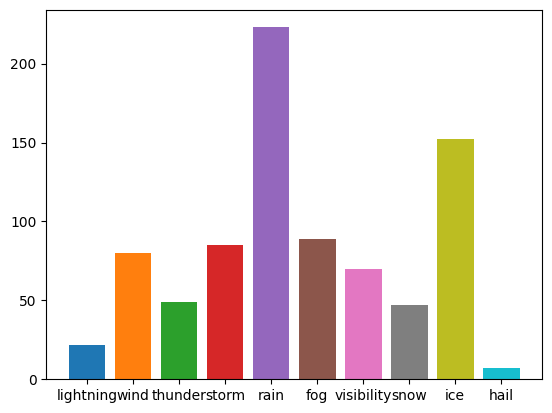

In [ ]:
# Weather related crashes graph
for keyword in keywords:
  crashes = df[df['Summary'].str.contains(keyword, case = False)].shape[0]
  plt.bar(keyword, crashes)

plt.show()

In [ ]:
# Crashes by season
season_map = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}

df.groupby(df['Month'].map(season_map)).size()

,0
Month,
Fall,312
Spring,263
Summer,301
Winter,347


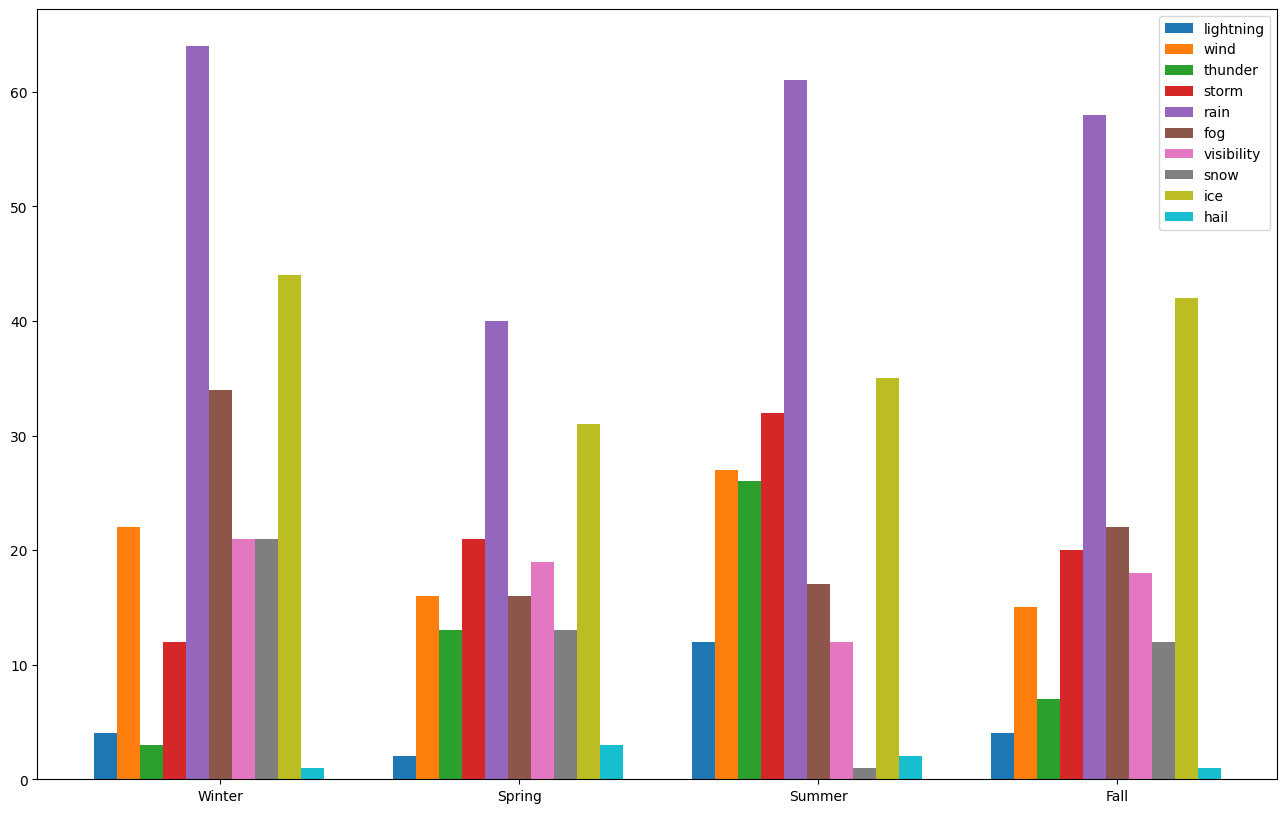

In [ ]:
# Weather related crashes by season

width = 0.2
offsets = np.arange(len(keywords)) * width - width * len(keywords) / 2
x = np.arange(4) * (width * len(keywords) + 3 * width)

fig, ax = plt.subplots(figsize = (16, 10))

crashes = [[], [], [], []]

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for i in range(len(seasons)):
  season = seasons[i]
  season_df = df[df['Month'].map(season_map) == season]

  for keyword in keywords:
    crashes[i].append(season_df[season_df['Summary'].str.contains(keyword, case = False)].shape[0])

crashes = np.asarray(crashes)
for i in range(len(keywords)):
  ax.bar(x + offsets[i], crashes[:, i], width = width, label = keywords[i])

ax.set_xticks(x, labels = seasons)

plt.legend()
plt.show()

In [ ]:
# Crashes per decade
df.groupby(df['Year'] // 10 * 10).size()

,0
Year,
1930,27
1940,76
1950,125
1960,233
1970,169
1980,145
1990,174
2000,164
2010,87


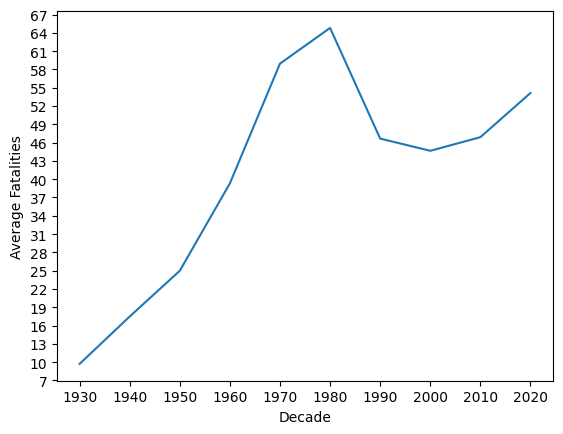

In [ ]:
# Average fatalities per decade
avg_fatal = df.groupby(df['Year'] // 10 * 10)['Fatalities'].mean().reset_index()

plt.xlabel("Decade")
plt.ylabel("Average Fatalities")
plt.xticks(avg_fatal['Year'])
plt.yticks(range(1, 70, 3))
plt.plot(avg_fatal['Year'], avg_fatal['Fatalities'])

plt.show()

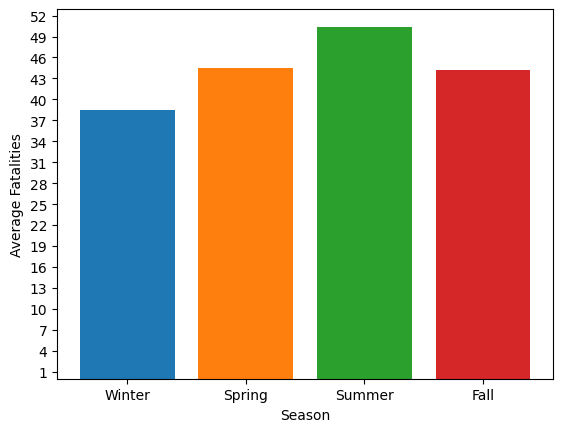

In [ ]:
# Average fatalities by season

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for season in seasons:
  season_df = df[df['Month'].map(season_map) == season]
  avg_fatal = season_df['Fatalities'].mean()

  plt.bar(season, avg_fatal)

plt.xlabel("Season")
plt.ylabel("Average Fatalities")
plt.yticks(range(1, 53, 3))

plt.show()

# Models

In [3]:
numerical_month_map = {
    "December": 12, "January": 1, "February": 2,
    "March": 3, "April": 4, "May": 5,
    "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11
}

weather_keywords = ['weather', 'storm', 'wind', 'fog', 'rain', 'lightning', 'snow', 'hail', 'icing', 'visibility', 'microburst']
mechanical_keywords = ['engine fail', 'mechanical fail', 'system fail', 'malfunction', 'landing gear', 'broke', 'inoperative']
human_keywords = ['error', 'misjudge', 'mistake', 'fatigue', 'distract', 'diorient', 'judgement', 'tired', 'low altitude', 'overran', 'collision', 'collide', 'cutoff']
fuel_keywords = ['fuel starvaiton', 'no fuel', 'ran out', 'low fuel']

model_df = df.copy()
model_df['Cause_Weather'] = df['Summary'].str.contains('|'.join(weather_keywords), case = False)
model_df['Cause_MechanicalFailure'] = df['Summary'].str.contains('|'.join(mechanical_keywords), case = False)
model_df['Cause_HumanError'] = df['Summary'].str.contains('|'.join(human_keywords), case = False)
model_df['Cause_Fuel'] = df['Summary'].str.contains('|'.join(fuel_keywords), case = False)
model_df['Survivors'] = df['Aboard'] > df['Fatalities']

drop_cols = [
    'Day', 'Location', 'Route', 'Passengers Aboard', 'Crew Aboard', 'Fatalities',
    'Passenger Fatalities', 'Crew Fatalities', 'Flight #', 'AC Type', 'Registration',
    'cn / ln', 'Summary'
]
model_df.drop(drop_cols, axis = 1, inplace = True)

model_df['Month'] = model_df['Month'].map(numerical_month_map)
model_df['Time'] = model_df['Time'].str.replace('\D', '', regex = True)
model_df[['Month', 'Time']] = model_df[['Month', 'Time']].astype(np.int64)

model_df.head(10)

,Month,Year,Time,Aboard,Ground,Cause_Weather,Cause_MechanicalFailure,Cause_HumanError,Cause_Fuel,Survivors
0,1,1930,1823,16,0,True,False,True,False,False
1,3,1931,1045,8,0,True,False,False,False,False
2,8,1934,2245,5,0,True,False,True,False,False
3,5,1935,330,14,0,True,False,False,False,True
4,8,1935,2345,4,0,False,True,False,False,False
5,10,1935,219,12,0,False,False,True,False,False
6,1,1936,1932,17,0,False,False,False,False,False
7,4,1936,1020,14,0,True,False,False,False,True
8,8,1936,2200,8,0,False,False,True,False,False
9,12,1936,314,7,0,False,True,False,False,False


In [5]:
features = model_df.drop('Survivors', axis = 1)
label = model_df['Survivors']
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, random_state = 7)

## Logistic Regression

In [23]:
# Hyperparameter tuning
params = {
    'tol': [0.000025, 0.00005, 0.000075, 0.0001],
    'C': [0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': [None, 'balanced'],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky']
}

estimator = LogisticRegression(random_state = 7, max_iter = 1000, n_jobs = -1)
grid_search = GridSearchCV(estimator, params, scoring = 'recall', n_jobs = -1)
grid_search.fit(x_train, y_train)

lr = grid_search.best_estimator_
pred = lr.predict(x_test)

grid_search.best_params_

{'C': 0.6,
 'class_weight': 'balanced',
 'solver': 'newton-cholesky',
 'tol': 2.5e-05}

In [119]:
print('Recall score:', recall_score(y_test, pred))
print('Accuracy score:', accuracy_score(y_test, pred))

Recall score: 0.5048543689320388
Accuracy score: 0.5836734693877551


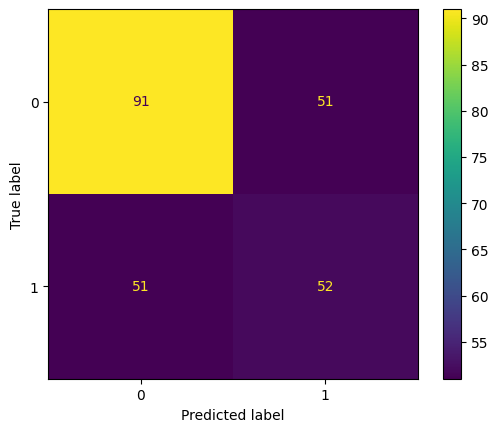

In [120]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [101]:
pd.DataFrame(data = lr.coef_, columns = [features.columns])

,Month,Year,Time,Aboard,Ground,Cause_Weather,Cause_MechanicalFailure,Cause_HumanError,Cause_Fuel
0,0.028921,-0.00057,0.000129,0.006267,-0.00671,-0.061002,0.267931,0.184902,1.87375


## Random Forest

In [7]:
# Hyperparameter tuning
params = {
    'n_estimators': list(range(100, 160, 10)),
    'max_depth': [None] + list(range(5, 9)),
    'max_features': ['sqrt'] + list(range(1, 4)),
    'max_leaf_nodes': [None] + list(range(10, 14))
}

estimator = RandomForestClassifier(n_jobs = 1, random_state = 7, class_weight = 'balanced')
grid_search = GridSearchCV(estimator, params, scoring = 'recall', n_jobs = -1)
grid_search.fit(x_train, y_train)

rf = grid_search.best_estimator_
pred = rf.predict(x_test)

grid_search.best_params_

{'max_depth': 5,
 'max_features': 2,
 'max_leaf_nodes': None,
 'n_estimators': 150}

In [25]:
# Create model using grid search params
rf = RandomForestClassifier(n_estimators = 150, max_features = 2, max_depth = 5, n_jobs = -1, random_state = 7, class_weight = 'balanced')
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

In [122]:
print('Recall score:', recall_score(y_test, pred))
print('Accuracy score:', accuracy_score(y_test, pred))

Recall score: 0.6213592233009708
Accuracy score: 0.6040816326530613


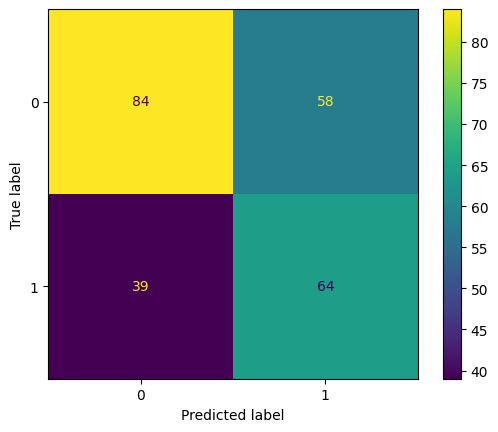

In [123]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [106]:
pd.DataFrame(data = [rf.feature_importances_], columns = [features.columns])

,Month,Year,Time,Aboard,Ground,Cause_Weather,Cause_MechanicalFailure,Cause_HumanError,Cause_Fuel
0,0.09044,0.16547,0.17563,0.377941,0.05903,0.01858,0.030478,0.023659,0.058773


## XGBoost

In [13]:
# Hyperparameter tuning
params = {
    'n_estimators': np.arange(130, 150, 5),
    'max_depth': np.arange(6, 10),
    'learning_rate': np.arange(0.01, 0.11, 0.01),
    'min_child_weight': [None, 1, 2, 3, 4],
    'subsample': [None] + list(np.arange(0.1, 1, 0.1))
}

estimator = XGBClassifier(max_leaves = 0, n_jobs = 1)
grid_search = GridSearchCV(estimator, params, scoring = 'recall', n_jobs = -1)
grid_search.fit(x_train, y_train)

xgb = grid_search.best_estimator_
pred = xgb.predict(x_test)

grid_search.best_params_

{'learning_rate': np.float64(0.06999999999999999),
 'max_depth': np.int64(6),
 'min_child_weight': 4,
 'n_estimators': np.int64(145),
 'subsample': np.float64(0.30000000000000004)}

In [26]:
# Create model with grid search params
xgb = XGBClassifier(n_estimators = 145, max_depth = 6, learning_rate = 0.07, min_child_weight = 4, subsample = 0.3, max_leaves = 0, n_jobs = 1)
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)

In [20]:
print('Recall score:', recall_score(y_test, pred))
print('Accuracy score:', accuracy_score(y_test, pred))

Recall score: 0.5922330097087378
Accuracy score: 0.636734693877551


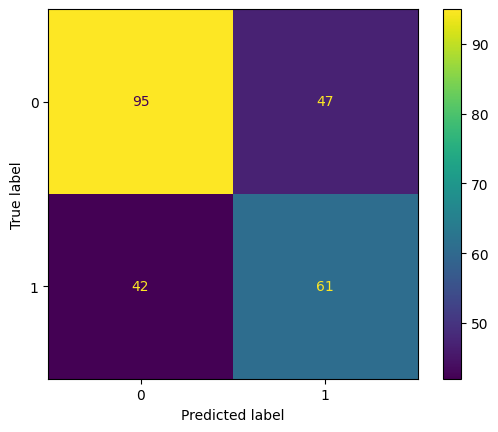

In [21]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Model Visualization

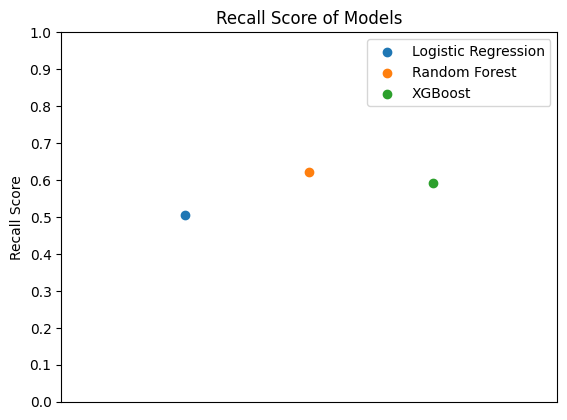

In [73]:
# Recall scores plotted against each other
models = [lr, rf, xgb]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
spacer = 0.5

for i in range(len(models)):
  model = models[i]
  pred = model.predict(x_test)
  score = recall_score(y_test, pred)

  plt.scatter(i * spacer, score, label = model_names[i])

plt.title("Recall Score of Models")
plt.ylabel("Recall Score")

plt.xlim(-0.5, 1.5)

plt.xticks([])
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend()
plt.show()

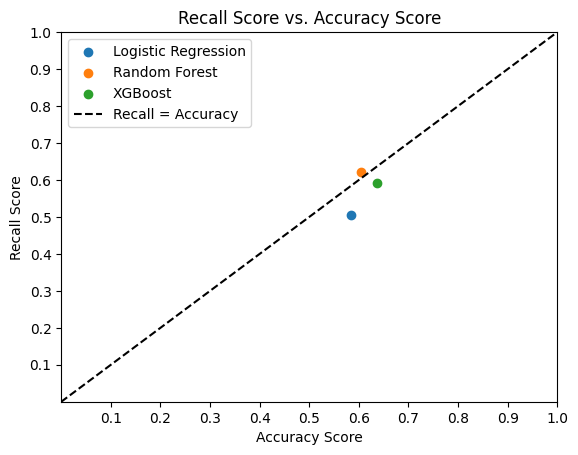

In [72]:
# Recall vs. accuracy
models = [lr, rf, xgb]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

for i in range(len(models)):
  model = models[i]
  pred = model.predict(x_test)
  recall = recall_score(y_test, pred)
  accuracy = accuracy_score(y_test, pred)

  plt.scatter(accuracy, recall, label = model_names[i])

plt.plot([-0.5, 1.5], [-0.5, 1.5], '--k', label = 'Recall = Accuracy')

plt.title("Recall Score vs. Accuracy Score")
plt.xlabel("Accuracy Score")
plt.ylabel("Recall Score")

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.yticks(np.arange(0.1, 1.1, 0.1))

plt.legend()
plt.show()